In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=e427ecc43c84c0e378b8f870a5fd130f9f47c8a8f801844f60903c3b478ee9fc
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
!pip install generic_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
from matplotlib import pyplot
from numpy import interp
import sklearn, tensorflow
import xlrd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import gzip
import pandas as pd
import pdb
import random
from random import randint
import scipy.io
from keras import layers
from keras.layers import Input, Dense
from keras import Model
from keras.models import Sequential, model_from_config,Model
from keras.layers import  Dropout, Activation, Flatten
from keras.layers import PReLU
import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam
from keras.layers import Normalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import Embedding
from keras import regularizers
from keras.constraints import MaxNorm
from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def prepare_data(seperate=False):
    print ("loading data")   #loading the dataset
    disease_sim = np.loadtxt("/content/drive/MyDrive/major/disease_similarity_matrix.txt",dtype=float)  #piRNA similarity data
    piRNA_sim  = np.loadtxt("/content/drive/MyDrive/major/RNA_similarity_matrix.txt",dtype=float)   #disease similarity data
    interaction = np.loadtxt("/content/drive/MyDrive/major/DIS_RNA_A (1).txt",dtype=int).astype(np.int64)   # piRNA - disease association
    link_number = 0
    train = []
    testf= []
    label1 = []
    label2 = []
    label22=[]
    ttf=[]
    for i in range(0, interaction.shape[0]):   # shape[0] returns m if interaction is m*n, ie, returns no. of rows of matrix
        for j in range(0, interaction.shape[1]):  # shape[0] returns no. of columns of matrix

            if interaction[i, j] == 1:                      #for associated
                label1.append(interaction[i,j])             #label1= labels for association(1)
                link_number = link_number + 1               #no. of associated samples
                #link_position.append([i, j])
                piRNA_sim_tmp = list(piRNA_sim[j])       # piRNA similarity vector for associated samples
                disease_sim_tmp = list(disease_sim[i])    # disease similarity vector for associated
                tmp_sim = (disease_sim_tmp,piRNA_sim_tmp)   #concatnated feature vector for an association
                train.append(tmp_sim)                       #train contains feature vectors of all associated samples
            else:                   #for no association
                label2.append(interaction[i,j])             #label2= labels for no association(0)
                piRNA_sim_tmp1 = list(piRNA_sim[j])
                disease_sim_tmp1 = list(disease_sim[i])
                test_sim= (disease_sim_tmp1,piRNA_sim_tmp1) #concatenated feature vector for not having association
                testf.append(test_sim)                    #testfnl contains feature vectors of all non associated samples
    print(len(train))
    print('************')
    print(len(testf))
    #print(link_number)
    print("link_number",link_number)   # no. of associated

    m = np.arange(len(label2))
    np.random.shuffle(m)

    for x in m:
        ttf.append(testf[x])
        label22.append(label2[x])
    #print('************')
    #print(ttfnl)
    #print('************')
    #print(label22)
    for x in range(0, link_number):                         #for equalizing positive and negative samples
        tfnl= ttf[x]                                    #tfnl= feature vector pair for no association
        lab= label22[x]                                      #lab= label of the above mentioned feature vector pair(0)
        #print(tfnl)
        #print('***')
        train.append(tfnl)                                  #append the non associated feature vector pairs to train till x<=no. of associated pairs
        label1.append(lab)                                   #append the labels of non associated pairs(0) to label1

    print((train))
    print(len(label1))
    print(len(testf))
    return train, label1, testf

In [ ]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = to_categorical(y)
    return y, encoder

def CNN_feature(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) #y_train and y_test contains corresponding labels
    x_train=x_train.reshape(-1,1,247,1)
    x_test=x_test.reshape(-1,1,247,1)
    print("x shape before reshaping=", x.shape)  #
    x = x.reshape(-1,1,247,1)
    print("x shape after reshaping=", x.shape)

    print("*********$$$$ x shape and y shape *******")

    print(x_train.shape)  # shape= (728,1,253,1) Total=910 samples
    print(x_test.shape)   #shape= (182,1,253,1)
    print(x.shape)        #shape= (910,1,253,1)
    print(x[0].shape)     # shape= (1,253,1) gives length of first row
    print(x[1].shape)     #shape = (1,253,1)
    #print(x[909].shape)   # shape = (1,253,1)
    #print(x[910].shape)   #out of bound
    print("********No. of rows and columns*****")


    print(x.shape[0])
    print(x.shape[1])
    print(x.shape[2])
    print(x.shape[3])

    #batch_size=32
    #epochs=2
    model = Sequential()
    return_sequences=True

    model.add(Convolution2D(16, (1,16),strides=(2,1), activation='relu', padding='same', data_format='channels_last',name='layer1_con1',input_shape=(1,247,1)))

    model.add(Dropout(0.5))

    model.add(MaxPooling2D(pool_size=(1,2),strides=(2,1), padding = 'same', data_format='channels_last',name = 'layer1_pool'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',  name='Dense-2'))
    model.add(Dropout(0.5))
    #model.add(Dense(1, activation='sigmoid', name='OutputLayer'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])
    model.summary()

    import numpy as np

    x_train = np.array(x_train) #changing to numpy array
    y_train = np.array(y_train)#changin to numpy array
    model.fit(x_train, y_train, epochs=20, batch_size=10,validation_split=0.1)
    from keras.models import Model
    dense1_layer_model = Model(inputs=model.input, outputs=model.get_layer('Dense-2').output)
    dense1_output = dense1_layer_model.predict(x)

    print("extracted feature shape=dense1_outout=",dense1_output.shape)
    print(dense1_output[0])
    return dense1_output

In [ ]:
def clas():
    X, labels,T = prepare_data(seperate = True)     #X= array of concatinated features,labels=corresponding labels

    X_data1, X_data2 = transfer_array_format(X)  # X-data1 = snoRNA features,  X_data2 = disease features


    print("************")
    print (X_data1.shape,X_data2.shape)
    print("******************")


    X_data1= np.concatenate((X_data1, X_data2 ), axis = 1)

    print("************")
    print (X_data1.shape)
    print("******************")


    y, encoder = preprocess_labels(labels)# labels labels_new
    num = np.arange(len(y))
    np.random.shuffle(num)
    X_data1 = X_data1[num]
    y = y[num]


    #####For CNN- call #######
    real__labels = []
    for val in y:
       if val[0] == 1:
          real__labels.append(0)
       else:
          real__labels.append(1)

    ######### CNN-call ends #########


    t=0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    X_data1 = CNN_feature(X_data1,real__labels)


    num_cross_val = 5
    all_performance = []
    all_performance_rf = []
    all_performance_bef = []
    all_performance_DNN = []
    all_performance_SDADNN = []
    all_performance_blend = []
    all_labels = []
    all_prob = {}

    all_prob[0] = []
    all_prob[1] = []
    all_prob[2] = []
    all_prob[3] = []
    all_averrage = []
    for fold in range(num_cross_val):
        train1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val != fold])
        test1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val == fold])
        train_label = np.array([x for i, x in enumerate(y) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(y) if i % num_cross_val == fold])
        #print("$$$$$$$$$$$$",test1)
        #print(test2)

        real_labels = []
        for val in test_label:
            if val[0] == 1:             #tuples in array, val[0]- first element of tuple
                real_labels.append(0)
            else:
                real_labels.append(1)

        train_label_new = []
        for val in train_label:
            if val[0] == 1:
                train_label_new.append(0)
            else:
                train_label_new.append(1)
        class_index = 0
        class_index = class_index + 1

        prefilter_train = train1
        prefilter_test = test1

        print('****************XGB***************')


        clf = XGBClassifier(n_estimators = 250, learning_rate = 0.2 , max_depth = 15 )

        clf.fit(prefilter_train, train_label_new)    #***Training

        ae_y_pred_prob = clf.predict_proba(prefilter_test)[:,1]   #**testing

        proba = transfer_label_from_prob(ae_y_pred_prob)

        print(X_data1.shape)


        acc, precision, sensitivity, specificity, MCC, f1_score = calculate_performace(len(real_labels), proba,  real_labels)

        fpr, tpr, auc_thresholds = roc_curve(real_labels, ae_y_pred_prob)
        auc_score = auc(fpr, tpr)
        scipy.io.savemat('raw_CNN',{'fpr':fpr,'tpr':tpr,'auc_score':auc_score})


        ## AUPR score add
        precision1, recall, pr_threshods = precision_recall_curve(real_labels, ae_y_pred_prob)
        aupr_score = auc(recall, precision1)
        print ("RAW DNN:",acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score)
        all_performance_DNN.append([acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score])
        t =t+1  #  AUC fold number

        pyplot.plot(fpr,tpr,label= 'ROC fold %d (AUC = %0.4f)' % (t, auc_score))
        mean_tpr += interp(mean_fpr, fpr, tpr) # one dimensional interpolation
        mean_tpr[0] = 0.0



        pyplot.xlabel('False positive rate, (1-Specificity)')
        pyplot.ylabel('True positive rate,(Sensitivity)')
        pyplot.title('Receiver Operating Characteristic curve: 5-Fold CV')
        pyplot.legend()

    mean_tpr /= num_cross_val
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)




    print('******* CNN-XGB *****')

    print ('mean performance of rf using raw feature')
    print (np.mean(np.array(all_performance_DNN), axis=0))
    Mean_Result=[]
    Mean_Result= np.mean(np.array(all_performance_DNN), axis=0)
    print ('---' * 20)
    print('Mean-Accuracy=', Mean_Result[0],'\n Mean-precision=',Mean_Result[1])
    print('Mean-Sensitivity=', Mean_Result[2], '\n Mean-Specificity=',Mean_Result[3])
    print('Mean-MCC=', Mean_Result[4],'\n' 'Mean-auc_score=',Mean_Result[5])
    print('Mean-Aupr-score=', Mean_Result[6],'\n' 'Mean_F1=',Mean_Result[7])
    print ('---' * 20)

    print(X_data1.shape)

    pyplot.plot(mean_fpr, mean_tpr,'--' ,linewidth=3.5,label='Mean ROC (AUC = %0.4f)' % Mean_Result[5])
    pyplot.legend()
    pyplot.show()

def transfer_label_from_prob(proba):
    label = [1 if val>=0.7 else 0 for val in proba]
    return label

In [ ]:
def calculate_performace(test_num, pred_y,  labels):
    tp =0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1

    acc = float(tp + tn)/test_num

    if tp == 0 and fp == 0:
        precision = 0
        MCC = 0
        f1_score=0
        sensitivity =  float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
    else:
        precision = float(tp)/(tp+ fp)
        sensitivity = float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
        MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
        f1_score= float(2*tp)/((2*tp)+fp+fn)

    return acc, precision, sensitivity, specificity, MCC,f1_score

def transfer_array_format(data):    #data=X  , X= all the miRNA features, disease features
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])   #contains miRNA features ?
        formated_matrix2.append(val[1])   #contains disease features ?

    return np.array(formated_matrix1), np.array(formated_matrix2)
def transfer_array_format(data):    #data=X  , X= all the miRNA features, disease features
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])   #contains miRNA features ?
        formated_matrix2.append(val[1])   #contains disease features ?
    return np.array(formated_matrix1), np.array(formated_matrix2)

loading data


<ipython-input-5-c08a2ddf24e4>:5: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  interaction = np.loadtxt("/content/drive/MyDrive/major/DIS_RNA_A (1).txt",dtype=int).astype(np.int64)   # piRNA - disease association


459
************
5481
link_number 459


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1_con1 (Conv2D)        (None, 1, 247, 16)        272       
                                                                 
 dropout_6 (Dropout)         (None, 1, 247, 16)        0         
                                                                 
 layer1_pool (MaxPooling2D)  (None, 1, 247, 16)        0         
                                                                 
 flatten_3 (Flatten)         (None, 3952)              0         
                                                                 
 Dense-2 (Dense)             (None, 128)               505984    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 1)                

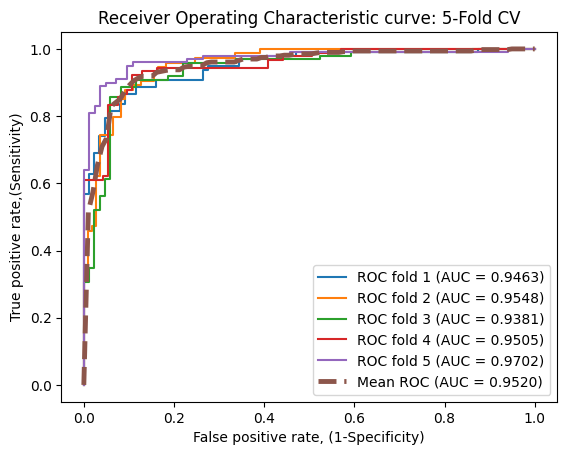

In [ ]:
if __name__=="__main__":
    clas()